## **Helper Functions and Packages**

In [5]:
pip install pandas_datareader

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import gym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import yfinance as yf
import torch.nn.functional as F

fewer_sp500_tickers = [
    "AAPL", "MSFT", "UNH", "LLY", "JPM", "JNJ", "XOM", "WMT", "PG", "CVX",
    "HD", "MRK", "COST", "PEP", "ADBE", "KO", "BAC", "ORCL", "INTC",
    "MCD", "ABT", "CSCO", "QCOM", "DHR", "NKE", "WFC", "TXN", "AMD",
    "NEE", "AMGN", "PM", "HON", "UNP", "UPS", "MS", "LOW", "BA", "IBM",
    "CAT", "MDT", "GS", "GE", "DE", "T", "LRCX", "ADI", "CI", "SYK",
    "MU", "SCHW", "ADP", "MMC", "BDX", "PFE", "ADSK", "SO", "PGR", "TGT",
    "AXP", "AON", "SLB", "CL", "APD", "AEP", "CSX", "F", "GM", "FDX",
    "DG", "NSC", "ITW"
]

sp500_tickers = [
    "AAPL", "MSFT", "GOOGL", "GOOG", "AMZN", "NVDA", "META", "TSLA", "BRK-B", "UNH",
    "LLY", "JPM", "V", "JNJ", "XOM", "WMT", "MA", "PG", "AVGO", "CVX", "HD", "MRK",
    "ABBV", "COST", "PEP", "ADBE", "KO", "BAC", "CRM", "ORCL", "TMO", "ACN", "INTC",
    "MCD", "ABT", "CSCO", "QCOM", "DHR", "NKE", "WFC", "TXN", "LIN", "AMD", "NEE",
    "AMGN", "PM", "HON", "UNP", "UPS", "MS", "SPGI", "RTX", "INTU", "LOW", "BA",
    "IBM", "AMT", "CAT", "MDT", "PLD", "GS", "ISRG", "CVS", "NOW", "BLK", "GE",
    "DE", "T", "LRCX", "ADI", "CI", "ZTS", "SYK", "C", "TJX", "MU", "SCHW", "ADP",
    "MMC", "BDX", "MO", "PFE", "BKNG", "CHTR", "CB", "REGN", "MDLZ", "VRTX", "USB",
    "PANW", "GILD", "ELV", "LMT", "ADSK", "SO", "PGR", "TGT", "DUK", "AXP",
    "HCA", "AON", "SLB", "CL", "APD", "EOG", "TJX", "AEP", "CSX", "F", "MAR", "GM",
    "ICE", "FDX", "DG", "MNST", "NSC", "EW", "ITW", "MET", "KHC", "TRV", "PSX", "MPC",
    "COF", "SHW", "OXY", "EMR", "SRE", "ROST", "HUM", "AZO", "CDNS", "KMB", "STZ",
    "ORLY", "ADM", "RMD", "PSA", "BIIB", "IDXX", "VLO", "TT", "CMG", "PRU", "WELL",
    "PCAR", "AFL", "SPG", "CTAS", "HAL", "EXC", "DLR", "AIG", "WMB", "ED", "HPQ",
    "YUM", "CTSH", "PAYX", "AMP", "TEL", "EBAY", "WBD", "OKE", "VICI", "PPG", "FITB",
    "EFX", "D", "DFS", "ALL", "MTB", "KEYS", "ANET", "OTIS", "HES", "BKR", "TTWO",
    "APH", "WEC", "ETN", "ECL", "ROK", "MLM", "AVB", "BAX", "NEM", "XYL", "CMS",
    "DOW", "RSG", "MCK", "GWW", "CHD", "CFG", "FAST", "CAH", "NUE", "VRSK", "LEN",
    "ULTA", "CCL", "CNP", "LDOS", "VTR", "CBRE", "IFF", "TSCO", "CAG", "ZBH", "BXP",
    "HOLX", "DPZ", "LUV", "IPG", "AKAM", "MKTX", "MAS", "DRI", "SWKS", "FTNT", "RHI",
    "FANG", "PPL", "AES", "AEE", "STX", "IR", "NTRS", "WY", "HIG", "DHI",
    "CLX", "ARE", "STE", "MTD", "CDW", "CMA", "INVH", "ALGN", "FE", "KIM",
    "ATO", "SNA", "GEN", "LHX", "BALL", "TER", "NDAQ", "BEN", "CRL", "PODD", "KR",
    "HBAN", "ZBRA", "LKQ", "APA", "NTAP", "SJM", "GLW", "TSN", "BWA", "HSIC", "CPB",
    "WRB", "JKHY", "NRG", "JBHT", "TFX", "XRAY", "NWS", "NWSA", "FOX", "FOXA"
]

In [2]:
import datetime
import gym
import numpy as np
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr

# ─── 1) PARAMETERS & TICKERS ────────────────────────────────────────────────────

start = datetime.datetime(1990, 1, 1)
end   = datetime.datetime(2019, 12, 31)

# your chosen subset of S&P500 tickers
tickers = fewer_sp500_tickers  # Make sure this is defined

# ─── 2) DOWNLOAD PRICE, VOLUME, DIVIDENDS ─────────────────────────────────────

# 2a) prices & volume
df = yf.download(tickers, start=start, end=end, auto_adjust=False)
prices = df['Close'].ffill().bfill()    # DataFrame (T, N)
vols   = df['Volume'].ffill().bfill()   # DataFrame (T, N)

# 2b) dividends series per ticker (as aligned DataFrames)
divs_dict = {}
for t in tickers:
    divs = yf.Ticker(t).dividends
    divs.index = divs.index.tz_localize(None)  # Make tz-naive
    divs = divs[start:end].astype(np.float32)
    divs_dict[t] = divs
divs_df = pd.DataFrame(divs_dict).reindex(prices.index).ffill().fillna(0.0)

# ─── 3) COMPUTE 30-DAY MA & SLOPE ───────────────────────────────────────────────

ma30 = prices.rolling(window=30).mean().ffill().bfill()  # (T, N)

# slope: linear fit over the last 30 days at each time t
slopes = pd.DataFrame(index=prices.index, columns=prices.columns, dtype=np.float32)
for t in range(len(prices)):
    window = prices.iloc[max(0, t-29):t+1]
    x = np.arange(len(window))
    for col in prices.columns:
        y = window[col].values
        if len(y) >= 2:
            m, _ = np.polyfit(x, y, 1)
        else:
            m = 0.0
        slopes.loc[prices.index[t], col] = np.float32(m)

# convert all to NumPy arrays aligned on the same datetime index
dates       = prices.index
prices_arr  = prices.values.astype(np.float32)     # (T, N)
vols_arr    = vols.values.astype(np.float32)       # (T, N)
divs_arr    = divs_df.values.astype(np.float32)    # (T, N)
ma30_arr    = ma30.values.astype(np.float32)       # (T, N)
slopes_arr  = slopes.values.astype(np.float32)     # (T, N)

# ─── 4) DOWNLOAD MACRO SERIES FROM FRED ────────────────────────────────────────

# UNRATE = unemployment rate (%), DGS10 = 10-yr Treasury yield (%), SP500EARN = S&P500 EPS
macro = pdr.DataReader(
    ['UNRATE','DGS10'], 
    'fred', 
    start, 
    end
).reindex(dates).ffill().bfill()

unemp_arr   = macro['UNRATE'].values.astype(np.float32)    # (T,)
irate_arr   = macro['DGS10'].values.astype(np.float32)     # (T,)


[*********************100%***********************]  71 of 71 completed


In [3]:
mu_price = prices_arr.mean(axis=0);   std_price = prices_arr.std(axis=0) + 1e-6
mu_div   = divs_arr.mean(axis=0);     std_div   = divs_arr.std(axis=0) + 1e-6
mu_vol   = vols_arr.mean(axis=0);     std_vol   = vols_arr.std(axis=0) + 1e-6
mu_ma30   = ma30_arr.mean(axis=0);     std_vol   = ma30_arr.std(axis=0) + 1e-6
mu_slopes   = slopes_arr.mean(axis=0);     std_slopes   = slopes_arr.std(axis=0) + 1e-6
mu_ir    = irate_arr.mean();           std_ir    = irate_arr.std()    + 1e-6

## **Trading Env**

In [4]:
import numpy as np
import gym
from gym import spaces
import yfinance as yf

class TradingEnv(gym.Env):
    def __init__(self, prices, divs, vols, irate,
                 initial_cash=10000, transaction_cost=0.00001,
                 use_snp500=True):
        super().__init__()
        # raw data
        self.prices_raw = prices
        self.divs_raw   = divs
        self.vols_raw   = vols
        self.irate_raw  = irate
        self.initial_cash     = initial_cash
        self.transaction_cost = transaction_cost
        self.T, self.N        = prices.shape

        # normalization stats
        self.mu_p, self.sd_p = mu_price, std_price
        self.mu_d, self.sd_d = mu_div,   std_div
        self.mu_v, self.sd_v = mu_vol,   std_vol
        self.mu_i, self.sd_i = mu_ir,    std_ir

        # S&P500 baseline
        self.use_snp500 = use_snp500
        if use_snp500:
            snp = yf.download('^GSPC', start=start, end=end, auto_adjust=False)['Close']
            snp = snp.ffill().bfill().values.astype(np.float32)
            self.snp500 = snp[:self.T]
        else:
            self.snp500 = np.ones(self.T, dtype=np.float32)

        self.action_space = spaces.Box(0,1,shape=(self.N+1,),dtype=np.float32)
        obs_dim = self.N*3 + self.N + 1 + 1
        self.observation_space = spaces.Box(-np.inf,np.inf,shape=(obs_dim,),dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.cash         = float(self.initial_cash)
        self.holdings     = np.zeros(self.N, dtype=np.float32)
        return self._get_obs()

    def _get_obs(self):
        t = self.current_step
        p = (self.prices_raw[t]   - self.mu_p) / self.sd_p
        d = (self.divs_raw[t] - self.mu_d) / self.sd_d
        v = (self.vols_raw[t]     - self.mu_v) / self.sd_v
        # Ensure i is a scalar
        i_val = self.irate_raw[t]
        # Convert to scalar if necessary
        if isinstance(i_val, pd.Series) or isinstance(i_val, np.ndarray):
            i_val = i_val.item()  # or i_val[0] depending on data structure
        i = (i_val - self.mu_i) / self.sd_i
        # Combine features
        feats = np.concatenate([
            p, 
            d, 
            v, 
            self.holdings, 
            [self.cash], 
            [i]  # Now [i] is a list containing a scalar
        ]).astype(np.float32)
        assert not np.isnan(feats).any(), "NaN in observation!"
        assert np.isfinite(feats).all(), "Infinite values in observation!"
        return feats

    def step(self, action):
        if self.current_step >= self.T - 1:
            return self._get_obs(), 0.0, True, {}

        action = np.clip(action, 1e-6, None)
        total = action.sum()
        if total <= 0 or np.isnan(total):
            action = np.zeros_like(action)
            action[-1] = 1.0  # all cash
        else:
            action = action / total

        prices = self.prices_raw[self.current_step]
        prices = np.clip(prices, 1e-3, None)  # prevent division by 0

        stock_vals  = self.holdings * prices
        total_value = stock_vals.sum() + self.cash

        target_stock_vals = action[:-1] * total_value
        target_cash       = action[-1]  * total_value

        new_holdings = target_stock_vals / prices
        trades       = np.abs(new_holdings - self.holdings) * prices
        turnover     = trades.sum()
        cost         = self.transaction_cost * turnover

        next_prices = self.prices_raw[self.current_step + 1]
        next_prices = np.clip(next_prices, 1e-3, None)

        next_stock_value = (new_holdings * next_prices).sum()
        next_total_value = next_stock_value + target_cash - cost

        if np.isnan(next_total_value) or np.isinf(next_total_value):
            reward = -1.0
            done = True
            return self._get_obs(), reward, done, {}

        port_ret = next_total_value / total_value - 1

        if self.use_snp500 and self.snp500 is not None:
            snp_ret = self.snp500[self.current_step + 1] / self.snp500[self.current_step] - 1
        else:
            p0 = prices.mean()
            p1 = next_prices.mean()
            snp_ret = p1 / p0 - 1

        reward = port_ret - snp_ret

        self.holdings  = new_holdings
        self.cash      = target_cash - cost
        self.current_step += 1
        done = (self.current_step >= self.T - 1)

        return self._get_obs(), reward, done, {}

    def render(self, mode="human"):
        prices = self.prices_raw[self.current_step - 1]
        val    = self.cash + (self.holdings * prices).sum()
        print(f"Day {self.current_step} | PortValue: ${val:.2f} | Cash: ${self.cash:.2f}")

## Actor Free CQL

In [85]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from collections import deque, namedtuple
from typing import List

# ----------------------
# 1. Dataset Preparation
# ----------------------

class HistoricalDataset:
    def __init__(self, prices, divs, vols, irate, 
                 window_size=30, transaction_cost=0.0001,
                 initial_cash=10000):
        self.prices = prices.astype(np.float32)
        self.divs = divs.astype(np.float32)
        self.vols = vols.astype(np.float32)
        self.irate = irate.astype(np.float32)
        self.T, self.N = prices.shape
        self.window = window_size
        self.tc = transaction_cost
        self.initial_cash = initial_cash
        
        # Initialize portfolio tracking arrays
        self.holdings = np.zeros((self.T, self.N), dtype=np.float32)
        self.cash = np.full(self.T, initial_cash, dtype=np.float32)
        
        # Calculate expert actions (momentum strategy)
        self.actions = self._generate_expert_actions()
        
    def _generate_expert_actions(self):
        """Risk-adjusted momentum strategy"""
        actions = np.zeros((self.T, self.N+1), dtype=np.float32)
        for t in range(self.window, self.T-1):
            window_returns = self.prices[t-self.window+1:t+1] / self.prices[t-self.window:t]
            log_returns = np.log(window_returns)
            mean_return = np.mean(log_returns, axis=0)
            std_return = np.std(log_returns, axis=0) + 1e-8  # avoid div by zero
            sharpe_ratio = mean_return / std_return

            top_stocks = np.argsort(-sharpe_ratio)[:10]
            weights = np.zeros(self.N+1)
            weights[top_stocks] = 0.95 / len(top_stocks)
            weights[-1] = 0.05  # Cash
            actions[t] = weights
            self._update_portfolio(t, weights)
        return actions

    def _update_portfolio(self, t, action):
        """Track portfolio evolution through time"""
        if t == 0:
            self.holdings[t] = 0
            self.cash[t] = self.initial_cash
            return
            
        # Calculate portfolio value before rebalancing
        prev_value = (self.holdings[t-1] * self.prices[t]).sum() + self.cash[t-1]
        
        # Calculate new allocations
        stock_alloc = action[:-1] * prev_value
        new_holdings = stock_alloc / self.prices[t]
        new_cash = action[-1] * prev_value
        
        # Apply transaction costs
        trades = np.abs(new_holdings - self.holdings[t-1])
        cost = self.tc * (trades * self.prices[t]).sum()
        
        # Update portfolio state
        self.holdings[t] = new_holdings
        self.cash[t] = new_cash - cost

    def create_offline_dataset(self):
        """Generate state-action-reward transitions"""
        dataset = []
        for t in range(self.window, self.T-1):
            state = self._get_state(t)
            action = self.actions[t]
            next_state = self._get_state(t+1)
            reward = self._calculate_reward(t, action)
            done = t == self.T-2
            dataset.append((state, action, reward, next_state, done))
        return dataset
    
    def _get_state(self, t):
        """Create normalized state observation with consistent 1D dimensions"""
        # Price features (per-stock)
        window_prices = self.prices[t-self.window:t]
        price_features = (window_prices[-1] - np.mean(window_prices, axis=0)) / (np.std(window_prices, axis=0) + 1e-6)
        
        # Dividend features (per-stock)
        div_feature = (self.divs[t] - np.mean(self.divs[:t], axis=0)) / (np.std(self.divs[:t], axis=0) + 1e-6)
        
        # Volume features (per-stock)
        vol_feature = (self.vols[t] - np.mean(self.vols[:t], axis=0)) / (np.std(self.vols[:t], axis=0) + 1e-6)
        
        # Interest rate feature (scalar -> 1D array)
        irate_feature = np.array([
            (self.irate[t] - np.mean(self.irate[:t])) / (np.std(self.irate[:t]) + 1e-6)
        ])
        
        # Holdings and cash (1D arrays)
        if t == 0:
            holdings = np.zeros(self.N)
            cash = np.array([1.0])  # 100% cash
        else:
            holdings = self.holdings[t-1]
            cash = np.array([self.cash[t-1] / self.initial_cash])
            
        return np.concatenate([
            price_features,    # Shape (N,)
            div_feature,       # Shape (N,)
            vol_feature,       # Shape (N,)
            irate_feature,     # Shape (1,)
            holdings,          # Shape (N,)
            cash               # Shape (1,)
        ]).astype(np.float32)
    
    def _calculate_reward(self, t, action):
            """Calculate portfolio return with proper array handling"""
            # Get previous portfolio value
            prev_stock_value = np.sum(self.holdings[t-1] * self.prices[t])
            prev_total_value = prev_stock_value + self.cash[t-1]

            # Calculate new allocations
            target_stock_values = action[:-1] * prev_total_value
            target_cash = action[-1] * prev_total_value

            # Update holdings and cash with transaction costs
            new_holdings = target_stock_values / self.prices[t]
            trades = np.abs(new_holdings - self.holdings[t-1])
            transaction_cost = self.tc * np.sum(trades * self.prices[t])

            self.holdings[t] = new_holdings
            self.cash[t] = target_cash - transaction_cost

            # Calculate returns
            new_stock_value = np.sum(self.holdings[t] * self.prices[t+1])
            new_total_value = new_stock_value + self.cash[t]
            port_return = (new_total_value / prev_total_value) - 1

            # Market return (S&P500 proxy)
            market_return = (self.prices[t+1].mean() / self.prices[t].mean()) - 1

            return (port_return - market_return) * 100

In [86]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push_batch(self, batch: List[Transition]):
        """Add multiple transitions at once"""
        self.buffer.extend(batch)
    
    def sample(self, batch_size, device):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        samples = [self.buffer[i] for i in indices]
        
        states, actions, rewards, next_states, dones = zip(*samples)
        
        return (
            torch.FloatTensor(np.array(states)).to(device),
            torch.FloatTensor(np.array(actions)).to(device),
            torch.FloatTensor(np.array(rewards)).unsqueeze(-1).to(device),
            torch.FloatTensor(np.array(next_states)).to(device),
            torch.FloatTensor(np.array(dones)).unsqueeze(-1).to(device)
        )
    
    def __len__(self):
        return len(self.buffer)

class QNetwork(nn.Module):
    def __init__(self, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(286 + action_dim, 256),  # Fixed input size
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    
    def forward(self, state, action):
        return self.net(torch.cat([state, action], dim=-1))

class BehaviorCloningPolicy(nn.Module):
    def __init__(self, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(286, 256),  # Fixed input size
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, action_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, state):
        return self.net(state)

class CQL:
    def __init__(self, action_dim, device,  # Removed state_dim parameter
                 gamma=0.99, tau=0.005, cql_weight=1.0, lr=3e-4):
        self.device = device
        
        # Q-networks with fixed dimensions
        self.q1 = QNetwork(action_dim).to(device)
        self.q2 = QNetwork(action_dim).to(device)
        self.target_q1 = QNetwork(action_dim).to(device)
        self.target_q2 = QNetwork(action_dim).to(device)
        self.target_q1.load_state_dict(self.q1.state_dict())
        self.target_q2.load_state_dict(self.q2.state_dict())
        
        # Behavior policy with fixed dimensions
        self.behavior_policy = BehaviorCloningPolicy(action_dim).to(device)
        
        # Optimizers
        self.q_optimizer = optim.Adam(list(self.q1.parameters()) + list(self.q2.parameters()), lr=lr)
        self.behavior_optimizer = optim.Adam(self.behavior_policy.parameters(), lr=lr)
        
        # Hyperparameters
        self.gamma = gamma
        self.tau = tau
        self.cql_weight = cql_weight
    
    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            action = self.behavior_policy(state).cpu().numpy()[0]
        return action
    
    def train_behavior_policy(self, buffer, batch_size, epochs=10):
        """Pre-train behavior policy using maximum likelihood with entropy regularization"""
        beta = 0.001  # Entropy regularization coefficient
        
        for _ in range(epochs):
            states, actions, _, _, _ = buffer.sample(batch_size, self.device)
            action_probs = self.behavior_policy(states)
            
            # Original negative log likelihood
            nll_loss = -torch.mean(torch.sum(actions * torch.log(action_probs + 1e-8), dim=-1))
            
            # Entropy regularization term
            entropy = -torch.sum(action_probs * torch.log(action_probs + 1e-8), dim=-1)
            entropy_loss = -torch.mean(entropy)  # Negative because we want to maximize entropy
            
            # Combined loss
            total_loss = nll_loss + beta * entropy_loss
            
            self.behavior_optimizer.zero_grad()
            total_loss.backward()
            self.behavior_optimizer.step()
    
    def update(self, buffer, batch_size):
        # Sample batch from offline dataset
        states, actions, rewards, next_states, dones = buffer.sample(batch_size, self.device)
        
        with torch.no_grad():
            # Compute target Q-values using behavior policy
            next_action_probs = self.behavior_policy(next_states)
            target_q1 = self.target_q1(next_states, next_action_probs)
            target_q2 = self.target_q2(next_states, next_action_probs)
            target_q = torch.min(target_q1, target_q2)
            target_values = rewards + (1 - dones) * self.gamma * target_q
        
        # Current Q estimates
        current_q1 = self.q1(states, actions)
        current_q2 = self.q2(states, actions)
        
        # TD errors
        q1_loss = torch.mean((current_q1 - target_values)**2)
        q2_loss = torch.mean((current_q2 - target_values)**2)
        
        # CQL regularization
        q1_cql = torch.logsumexp(self.q1(states, actions), dim=-1).mean()
        q2_cql = torch.logsumexp(self.q2(states, actions), dim=-1).mean()
        cql_loss = (q1_cql + q2_cql) / 2
        
        # Total loss
        total_loss = q1_loss + q2_loss + self.cql_weight * cql_loss
        
        # Optimize Q-networks
        self.q_optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q1.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(self.q2.parameters(), 1.0)
        self.q_optimizer.step()
        
        # Update target networks
        with torch.no_grad():
            for param, target_param in zip(self.q1.parameters(), self.target_q1.parameters()):
                target_param.data.mul_(1 - self.tau).add_(param.data, alpha=self.tau)
            for param, target_param in zip(self.q2.parameters(), self.target_q2.parameters()):
                target_param.data.mul_(1 - self.tau).add_(param.data, alpha=self.tau)
        
        return total_loss.item()

In [87]:
# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dim = 71 * 4 * 2 # Adjusted based on state features
action_dim = 71 + 1
batch_size = 512
num_epochs = 50000

# Load and preprocess data
dataset = HistoricalDataset(prices_arr, divs_arr, vols_arr, irate_arr)
offline_data = dataset.create_offline_dataset()

# Initialize replay buffer
buffer = ReplayBuffer(capacity=len(offline_data))
buffer.push_batch(offline_data)

# Initialize CQL agent
free_agent = CQL(action_dim, device)

# Pretrain behavior policy
print("Pretraining behavior policy...")
free_agent.train_behavior_policy(buffer, batch_size, epochs=50)

# Main training loop
print("Starting CQL training...")
for epoch in range(num_epochs):
    loss = free_agent.update(buffer, batch_size)

    if epoch % 5000 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {loss:.4f}")

# Save trained model
torch.save({
    'q1_state_dict': free_agent.q1.state_dict(),
    'q2_state_dict': free_agent.q2.state_dict(),
    'behavior_policy_state_dict': free_agent.behavior_policy.state_dict()
}, "cql_stock_trading.pth")


Pretraining behavior policy...
Starting CQL training...
Epoch 1/50000 | Loss: 0.9749
Epoch 5001/50000 | Loss: -7.2219
Epoch 10001/50000 | Loss: -12.4641
Epoch 15001/50000 | Loss: -16.3681
Epoch 20001/50000 | Loss: -19.4515
Epoch 25001/50000 | Loss: -21.3297
Epoch 30001/50000 | Loss: -22.8220
Epoch 35001/50000 | Loss: -23.8654
Epoch 40001/50000 | Loss: -25.3028
Epoch 45001/50000 | Loss: -25.5369


In [80]:
##Get test sample

import random
sampled_tickers = random.sample(sp500_tickers, 71)

[*********************100%***********************]  71 of 71 completed
[*********************100%***********************]  1 of 1 completed
/scratch/4632092.1.cds-gpu/ipykernel_527414/3689068741.py:190: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Benchmark (S&P500) Return: {float(bench_return):.2f}%")


Evaluation from 2020-01-02 to 2025-04-11
Portfolio Cumulative Return: 87.47%
Benchmark (S&P500) Return: 65.80%


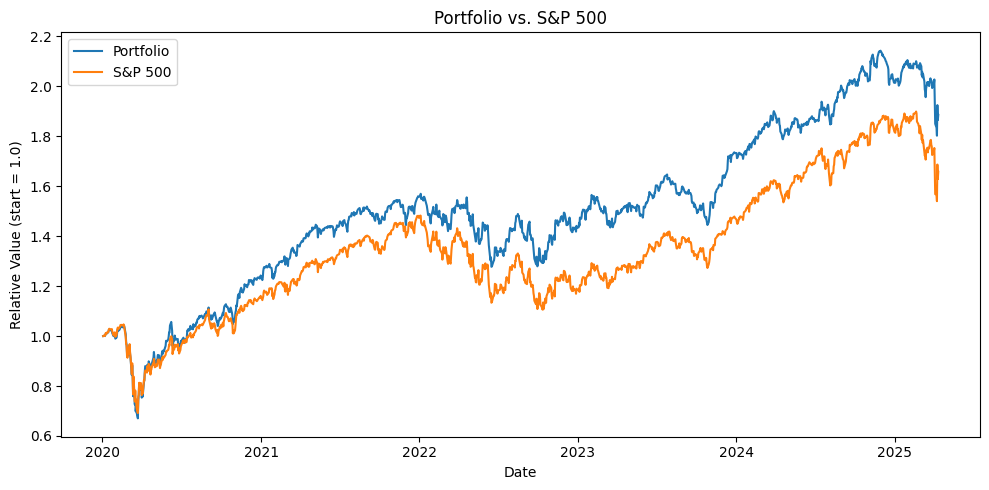

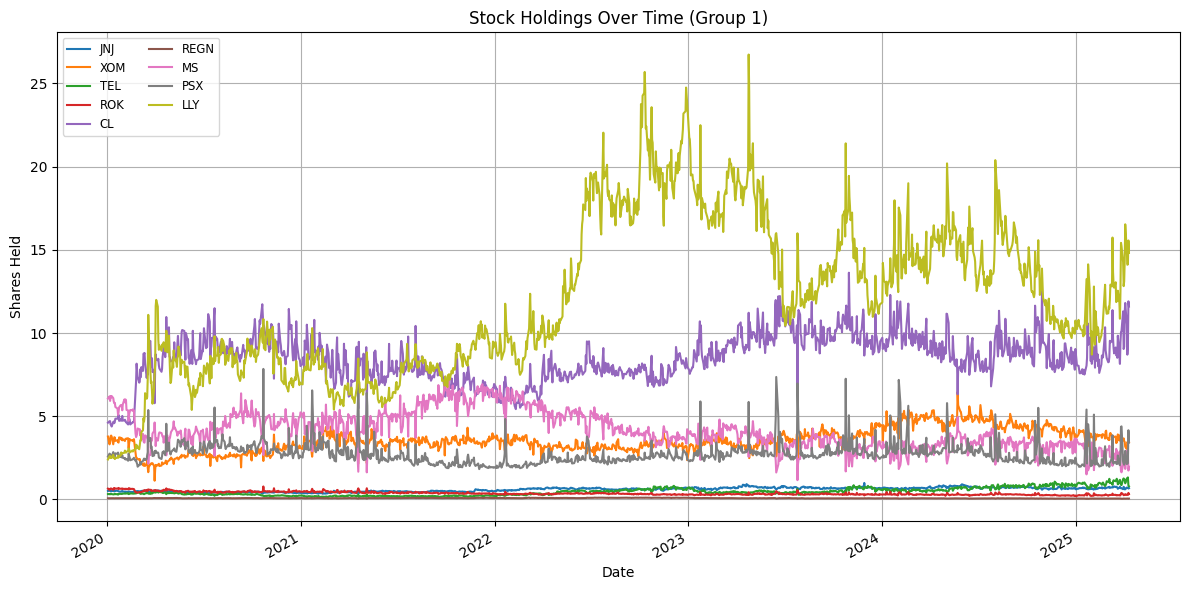

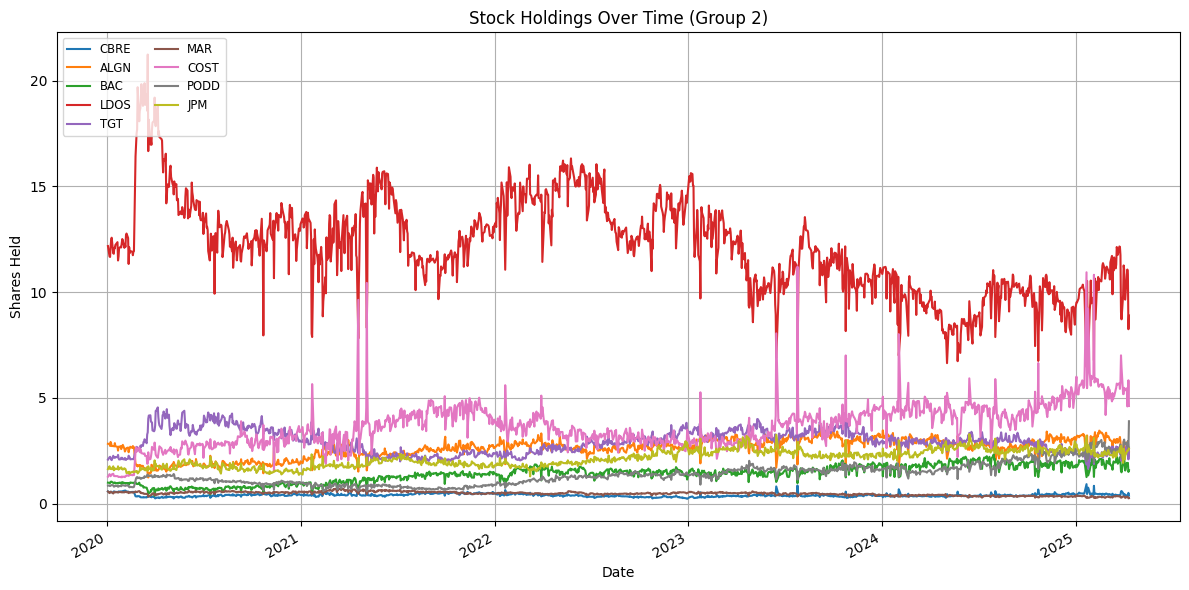

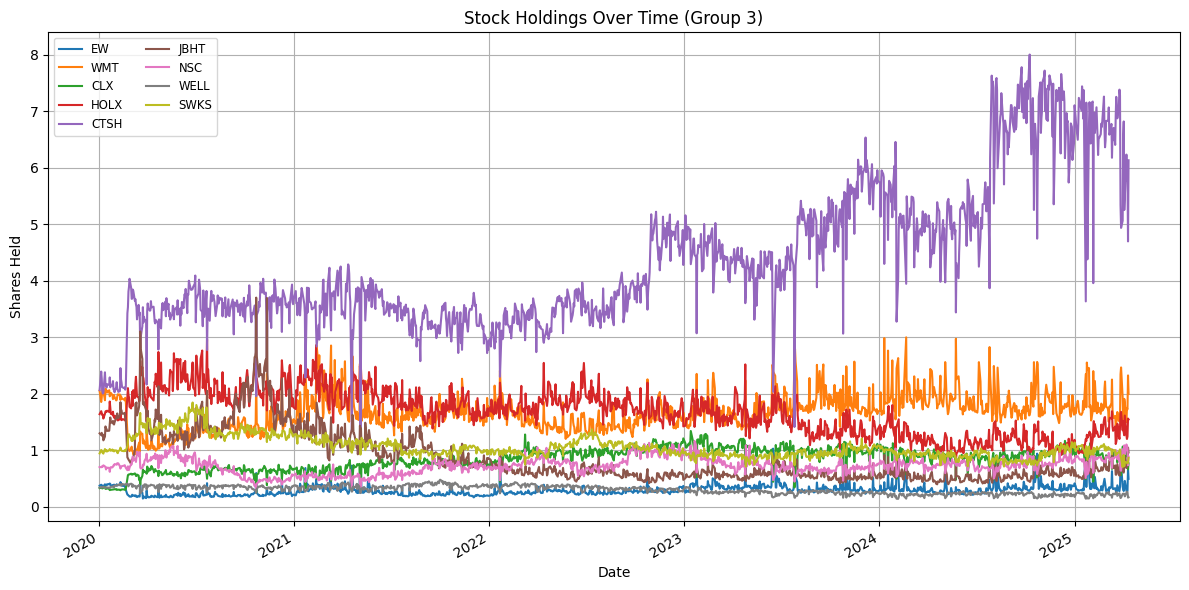

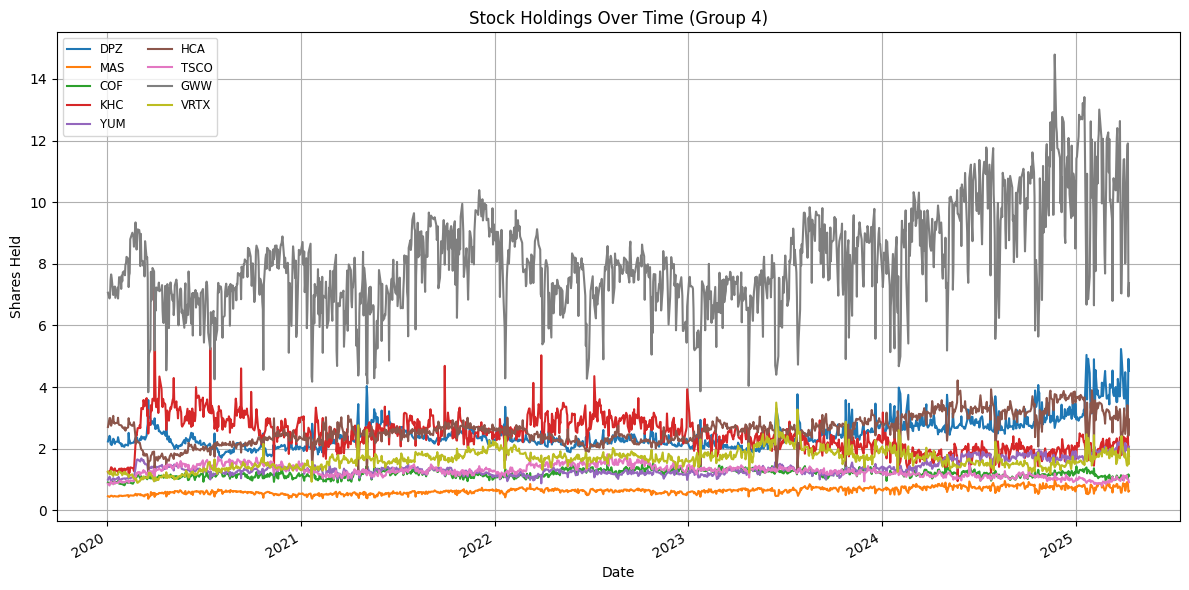

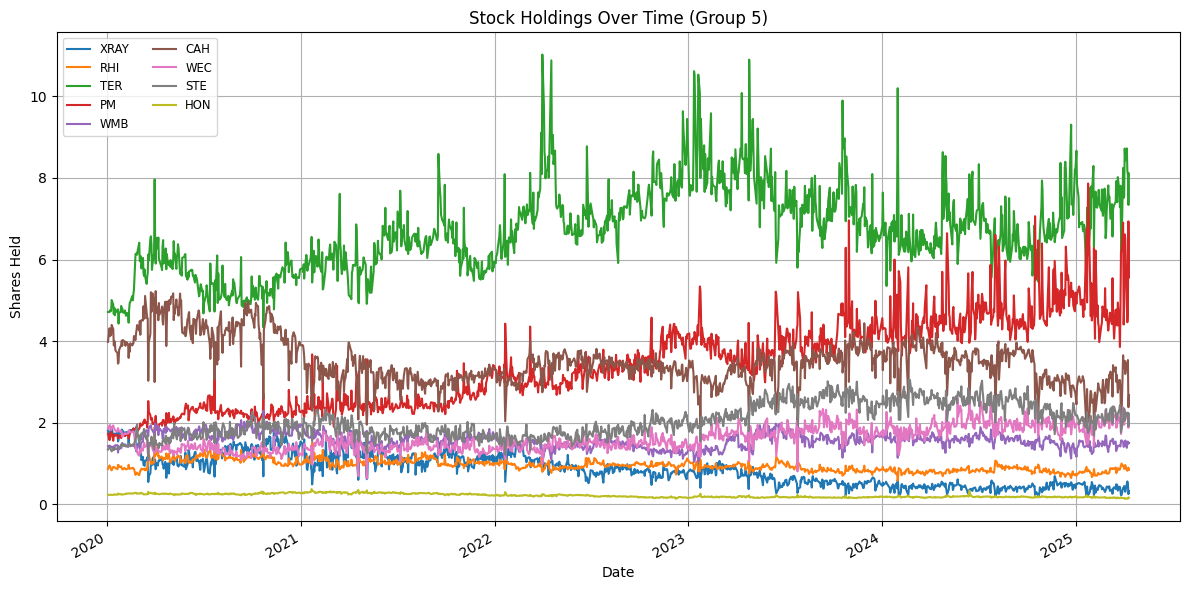

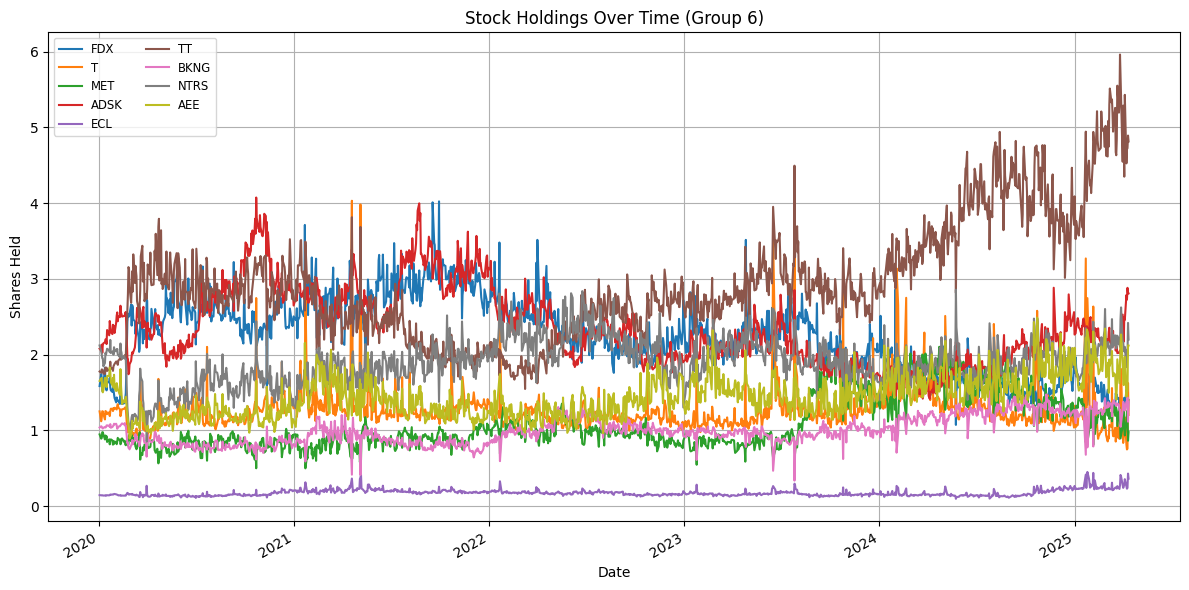

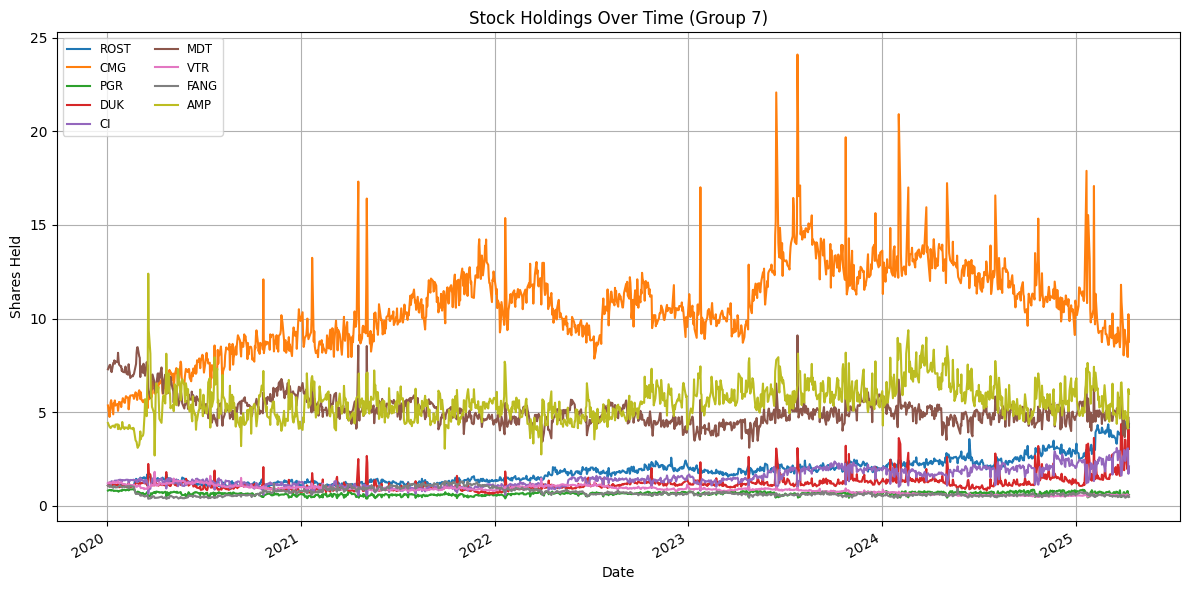

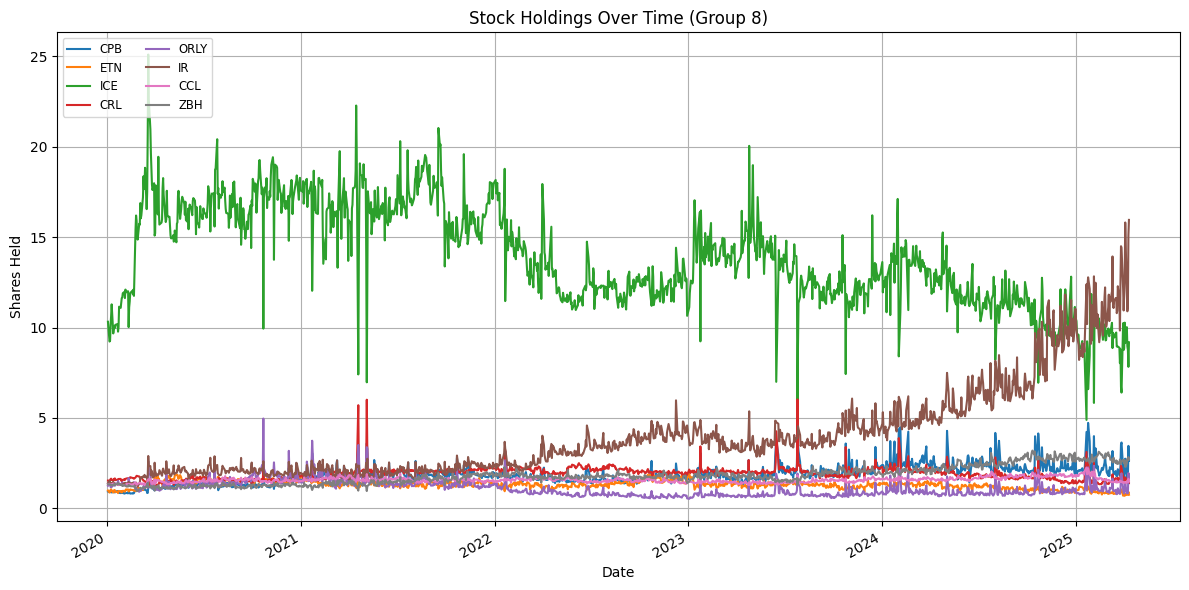

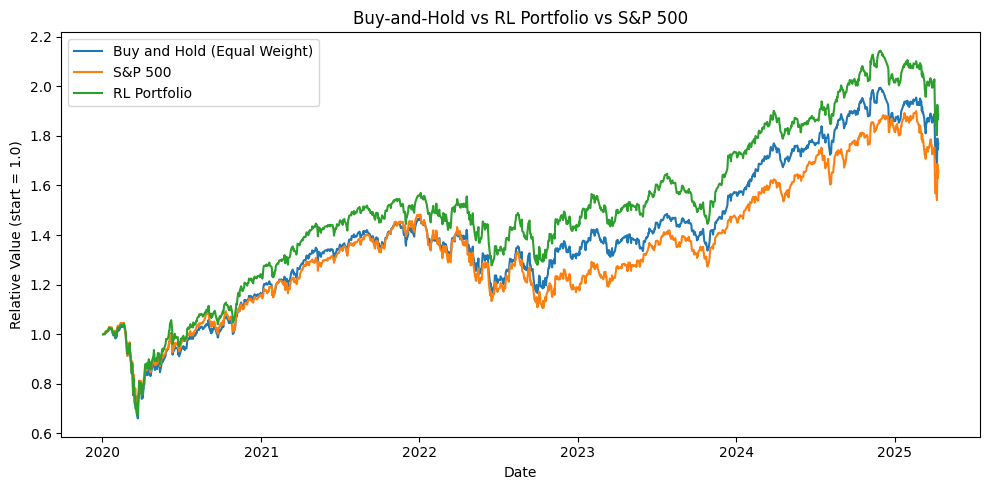

model_return: 87.47374743686261 sp500_return: [65.79933] buy_and_hold_return: 76.82999055654969


/scratch/4632092.1.cds-gpu/ipykernel_527414/3689068741.py:293: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bh_return = (portfolio_val[-1] / portfolio_val[0] - 1) * 100


In [88]:
import gym
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
from gym import spaces

# ------------------------------------------------------------------------
# Full evaluate_agent with individual-holdings plots (8 panels)
# ------------------------------------------------------------------------
def evaluate_agent(agent,
                   tickers,
                   start_date='2020-01-01',
                   end_date=None,
                   initial_cash=100_000,
                   transaction_cost=1e-5,
                   device=None):
    # --------------------------------------------------------------------
    # 1) Download and prepare market data (prices & S&P500)
    # --------------------------------------------------------------------
    price_df = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        auto_adjust=True
    )["Close"].ffill().bfill()
    prices = price_df.values.astype(np.float32)
    dates  = price_df.index

    snp_series = yf.download(
        '^GSPC',
        start=start_date,
        end=end_date,
        auto_adjust=True
    )["Close"].ffill().bfill()
    snp_vals = snp_series.values.astype(np.float32)

    # --------------------------------------------------------------------
    # 2) Assume these arrays & stats were computed during training:
    #    divs_arr, vols_arr, irate_arr,
    #    mu_price, std_price,
    #    mu_div,   std_div,
    #    mu_vol,   std_vol,
    #    mu_ir,    std_ir
    # --------------------------------------------------------------------

    class EvalEnv(gym.Env):
        def __init__(self, prices, divs, vols, irate, snp500,
                     initial_cash=10_000, transaction_cost=1e-5):
            super().__init__()
            self.prices_raw       = prices
            self.divs_raw         = divs
            self.vols_raw         = vols
            self.irate_raw        = irate
            self.snp500           = snp500[: prices.shape[0]]
            self.T, self.N        = prices.shape
            self.initial_cash     = initial_cash
            self.transaction_cost = transaction_cost

            # normalization stats from training
            self.mu_p, self.sd_p = mu_price, std_price
            self.mu_d, self.sd_d = mu_div,   std_div
            self.mu_v, self.sd_v = mu_vol,   std_vol
            self.mu_i, self.sd_i = mu_ir,    std_ir

            self.action_space = spaces.Box(
                low=0, high=1, shape=(self.N + 1,), dtype=np.float32
            )
            obs_dim = self.N*3 + self.N + 1 + 1
            self.observation_space = spaces.Box(
                low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32
            )

        def reset(self):
            self.current_step = 0
            self.cash         = float(self.initial_cash)
            self.holdings     = np.zeros(self.N, dtype=np.float32)
            return self._get_obs()

        def _get_obs(self):
            t = self.current_step
            p = (self.prices_raw[t] - self.mu_p) / self.sd_p
            d = (self.divs_raw[t]   - self.mu_d) / self.sd_d
            v = (self.vols_raw[t]   - self.mu_v) / self.sd_v
            i = (self.irate_raw[t]  - self.mu_i) / self.sd_i
            return np.concatenate([
                p, d, v,
                self.holdings,
                [self.cash],
                [i]
            ]).astype(np.float32)

        def step(self, action):
            # terminal check
            if self.current_step >= self.T - 1:
                return self._get_obs(), 0.0, True, {}

            # normalize & clip action
            action = np.clip(action, 1e-6, None)
            total  = action.sum()
            if total <= 0 or np.isnan(total):
                action = np.zeros_like(action)
                action[-1] = 1.0
            else:
                action = action / total

            prices     = np.clip(self.prices_raw[self.current_step], 1e-3, None)
            stock_vals = self.holdings * prices
            tot_value  = stock_vals.sum() + self.cash

            # compute targets
            target_stock_vals = action[:-1] * tot_value
            target_cash       = action[-1]  * tot_value
            new_holdings      = target_stock_vals / prices

            # transaction cost
            trades   = np.abs(new_holdings - self.holdings) * prices
            turnover = trades.sum()
            cost     = self.transaction_cost * turnover

            # next step prices
            next_prices = np.clip(
                self.prices_raw[self.current_step + 1], 1e-3, None
            )
            next_stock_value = (new_holdings * next_prices).sum()
            next_tot_value   = next_stock_value + target_cash - cost

            # handle numerical issues
            if np.isnan(next_tot_value) or np.isinf(next_tot_value):
                return self._get_obs(), -1.0, True, {}

            # reward = (portfolio return) - (S&P return)
            port_ret = next_tot_value / tot_value - 1
            snp_ret  = (
                self.snp500[self.current_step + 1]
                / self.snp500[self.current_step]
                - 1
            )
            reward = port_ret - snp_ret

            # state update
            self.holdings     = new_holdings
            self.cash         = target_cash - cost
            self.current_step += 1
            done = (self.current_step >= self.T - 1)

            return self._get_obs(), reward, done, {}

    # --------------------------------------------------------------------
    # 3) Instantiate env and run deterministic evaluation
    # --------------------------------------------------------------------
    env = EvalEnv(
        prices, divs_arr, vols_arr, irate_arr, snp_vals,
        initial_cash=initial_cash,
        transaction_cost=transaction_cost
    )

    state = env.reset()

    portf_vals, bench_vals = [], []
    holdings_history = []
    dates_hist      = []

    # --------------------------------------------------------------------
    # 4) Evaluation loop with history recording
    # --------------------------------------------------------------------
    while True:
        action = agent.select_action(state)
        next_state, _, done, _ = env.step(action)
        state = next_state

        t = env.current_step
        dates_hist.append(dates[t])
        portf_vals.append(env.cash + (env.holdings * env.prices_raw[t]).sum())
        bench_vals.append(env.snp500[t])
        holdings_history.append(env.holdings.copy())

        if done:
            break

    # --------------------------------------------------------------------
    # 5) Print returns
    # --------------------------------------------------------------------
    cum_return   = (portf_vals[-1] / initial_cash - 1) * 100
    bench_return = (bench_vals[-1] / bench_vals[0] - 1) * 100
    print(f"Evaluation from {dates[0].date()} to {dates[-1].date()}")
    print(f"Portfolio Cumulative Return: {cum_return:.2f}%")
    print(f"Benchmark (S&P500) Return: {float(bench_return):.2f}%")

    # --------------------------------------------------------------------
    # 6) Normalize & plot Portfolio vs. S&P500
    # --------------------------------------------------------------------
    portf_arr  = np.array(portf_vals, dtype=np.float32)
    bench_arr  = np.array(bench_vals, dtype=np.float32)
    norm_pf    = portf_arr / portf_arr[0]
    norm_bench = bench_arr / bench_arr[0]
    xs = dates[1 : 1 + len(norm_pf)]

    plt.figure(figsize=(10, 5))
    plt.plot(xs, norm_pf,    label='Portfolio')
    plt.plot(xs, norm_bench, label='S&P 500')
    plt.xlabel('Date')
    plt.ylabel('Relative Value (start = 1.0)')
    plt.title('Portfolio vs. S&P 500')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --------------------------------------------------------------------
    # 7) Build holdings DataFrame
    # --------------------------------------------------------------------
    holdings_arr = np.vstack(holdings_history)
    holdings_df  = pd.DataFrame(
        holdings_arr,
        index=pd.to_datetime(dates_hist),
        columns=tickers
    )

    # --------------------------------------------------------------------
    # 8) Plot individual holdings in 8 panels
    # --------------------------------------------------------------------
    num_plots        = 8
    tickers_per_plot = int(np.ceil(len(tickers) / num_plots))

    for i in range(num_plots):
        start_i = i * tickers_per_plot
        end_i   = start_i + tickers_per_plot
        subset  = tickers[start_i:end_i]
        if not subset:
            continue

        fig, ax = plt.subplots(figsize=(12, 6))
        holdings_df[subset].plot(ax=ax)

        ax.set(
            xlabel="Date",
            ylabel="Shares Held",
            title=f"Stock Holdings Over Time (Group {i+1})"
        )
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
        ax.legend(loc="upper left", ncol=2, fontsize="small")
        ax.grid(True)

        plt.tight_layout()
        plt.show()
        
    # --------------------------------------------------------------------
    # 9) Plot Buy-and-Hold Portfolio for Comparison
    # --------------------------------------------------------------------
    buy_hold_prices = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        auto_adjust=True,
        progress=False
    )["Close"].ffill().bfill()

    # Align with evaluation period
    buy_hold_prices = buy_hold_prices.loc[dates_hist]
    buy_hold_prices = buy_hold_prices.dropna(axis=1)  # Drop tickers that failed

    if not buy_hold_prices.empty:
        # Equal weight initial investment
        initial_allocation = initial_cash / len(buy_hold_prices.columns)
        num_shares = initial_allocation / buy_hold_prices.iloc[0]

        # Calculate portfolio value over time
        portfolio_val = (buy_hold_prices * num_shares).sum(axis=1)

        # Normalize
        portfolio_val_norm = portfolio_val / portfolio_val.iloc[0]
        benchmark_val_norm = bench_arr / bench_arr[0]
        xs_bh = pd.to_datetime(dates_hist)

        plt.figure(figsize=(10, 5))
        plt.plot(xs_bh, portfolio_val_norm, label='Buy and Hold (Equal Weight)')
        plt.plot(xs_bh, benchmark_val_norm, label='S&P 500')
        plt.plot(xs_bh, norm_pf, label='RL Portfolio')
        plt.xlabel('Date')
        plt.ylabel('Relative Value (start = 1.0)')
        plt.title('Buy-and-Hold vs RL Portfolio vs S&P 500')
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("Buy-and-hold price data could not be fully aligned with evaluation dates.")

    model_return = cum_return
    sp500_return = (bench_vals[-1] / bench_vals[0] - 1) * 100
    bh_return = (portfolio_val[-1] / portfolio_val[0] - 1) * 100

    print(f"model_return: {model_return} sp500_return: {sp500_return} buy_and_hold_return: {bh_return}")

# ------------------------------------------------------------------------
# Example usage
# ------------------------------------------------------------------------
if __name__ == "__main__":
    swag = evaluate_agent(
        free_agent,
        sampled_tickers,
        start_date='2020-01-01',
        end_date='2025-04-14',
        initial_cash=10000,
        transaction_cost=1e-5,
        device=device
    )

## Actor-Critic CQL

In [75]:
# ----------------------
# 0. Transition Definition
# ----------------------
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

# ----------------------
# 1. Dataset Preparation
# ----------------------
class HistoricalDataset:
    def __init__(self, prices, divs, vols, irate,
                 window_size=30, transaction_cost=0.0001,
                 initial_cash=10000):
        self.prices = prices.astype(np.float32)
        self.divs = divs.astype(np.float32)
        self.vols = vols.astype(np.float32)
        self.irate = irate.astype(np.float32)
        self.T, self.N = prices.shape
        self.window = window_size
        self.tc = transaction_cost
        self.initial_cash = initial_cash
        self.holdings = np.zeros((self.T, self.N), dtype=np.float32)
        self.cash = np.full(self.T, initial_cash, dtype=np.float32)
        self.actions = self._generate_expert_actions()

    def _generate_expert_actions(self):
        """Generate random allocation vectors for each time step."""
        actions = np.zeros((self.T, self.N+1), dtype=np.float32)
        for t in range(self.window, self.T-1):
            # sample uniform random weights and normalize
            w = np.random.rand(self.N+1).astype(np.float32)
            w /= (w.sum() + 1e-8)
            actions[t] = w
            # update holdings based on this random action
            self._update_portfolio(t, w)
        return actions

    def _update_portfolio(self, t, action):
        if t == 0:
            self.holdings[t] = 0
            self.cash[t] = self.initial_cash
            return
        prev_val = (self.holdings[t-1] * self.prices[t]).sum() + self.cash[t-1]
        alloc = action[:-1] * prev_val
        new_h = alloc / self.prices[t]
        new_c = action[-1] * prev_val
        trades = np.abs(new_h - self.holdings[t-1]) * self.prices[t]
        cost = self.tc * trades.sum()
        self.holdings[t] = new_h
        self.cash[t] = new_c - cost

    def create_offline_dataset(self):
        dataset = []
        for t in range(self.window, self.T-1):
            s = self._get_state(t)
            a = self.actions[t]
            s2 = self._get_state(t+1)
            r = self._calculate_reward(t, a)
            d = (t == self.T-2)
            dataset.append(Transition(s, a, r, s2, d))
        return dataset

    def _get_state(self, t):
        wp = self.prices[t-self.window:t]
        pf = (wp[-1] - wp.mean(0)) / (wp.std(0) + 1e-6)
        df = (self.divs[t] - self.divs[:t].mean(0)) / (self.divs[:t].std(0) + 1e-6)
        vf = (self.vols[t] - self.vols[:t].mean(0)) / (self.vols[:t].std(0) + 1e-6)
        ir = (self.irate[t] - self.irate[:t].mean()) / (self.irate[:t].std() + 1e-6)
        hold = self.holdings[t-1] if t>0 else np.zeros(self.N, dtype=np.float32)
        cash = np.array([self.cash[t-1]/self.initial_cash]) if t>0 else np.array([1.0], dtype=np.float32)
        return np.concatenate([pf, df, vf, [ir], hold, cash]).astype(np.float32)

    def _calculate_reward(self, t, action):
        prev_val = (self.holdings[t-1] * self.prices[t]).sum() + self.cash[t-1]
        tgt = action[:-1] * prev_val
        nh = tgt / self.prices[t]
        trades = np.abs(nh - self.holdings[t-1]) * self.prices[t]
        cost = self.tc * trades.sum()
        self.holdings[t] = nh
        self.cash[t] = action[-1] * prev_val - cost
        new_val = (self.holdings[t] * self.prices[t+1]).sum() + self.cash[t]
        port_ret = new_val / prev_val - 1
        mkt_ret = self.prices[t+1].mean() / self.prices[t].mean() - 1
        return float((port_ret - mkt_ret) * 100)

In [76]:
# ----------------------
# 2. Actor-Critic CQL Agent
# ----------------------
class ReplayBuffer:
    def __init__(self, capacity): self.buffer = deque(maxlen=capacity)
    def push(self, transition): self.buffer.append(transition)
    def sample(self, bs, dev):
        idx = np.random.choice(len(self.buffer), bs, replace=False)
        batch = [self.buffer[i] for i in idx]
        s,a,r,s2,d = zip(*batch)
        return (torch.FloatTensor(s).to(dev), torch.FloatTensor(a).to(dev),
                torch.FloatTensor(r).unsqueeze(-1).to(dev), torch.FloatTensor(s2).to(dev),
                torch.FloatTensor(d).unsqueeze(-1).to(dev))
    def __len__(self): return len(self.buffer)

class QNetwork(nn.Module):
    def __init__(self, sd, ad):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(sd+ad,256), nn.LayerNorm(256), nn.ReLU(),
            nn.Linear(256,256), nn.LayerNorm(256), nn.ReLU(),
            nn.Linear(256,1)
        )
    def forward(self,s,a): return self.net(torch.cat([s,a],-1))

class PolicyNetwork(nn.Module):
    def __init__(self, sd, ad):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(sd,256), nn.LayerNorm(256), nn.ReLU(),
            nn.Linear(256,256), nn.LayerNorm(256), nn.ReLU()
        )
        self.mean = nn.Linear(256,ad)
        self.log_std = nn.Linear(256,ad)
    def forward(self,s):
        x = self.net(s)
        m = self.mean(x)
        ls = self.log_std(x).clamp(-20,2)
        return m, ls.exp()
    def sample(self,s):
        m,sd = self(s)
        dist = torch.distributions.Normal(m,sd)
        z = dist.rsample()
        a = z.tanh()
        logp = dist.log_prob(z) - torch.log(1 - a.pow(2) + 1e-6)
        return a, logp.sum(-1,keepdim=True)

class ActorCriticCQLAgent:
    def __init__(self, sd, ad, device, gamma=0.99, tau=0.005, ca=1.0, lr=3e-4):
        self.dev, self.g, self.tau, self.ca = device, gamma, tau, ca
        self.q1 = QNetwork(sd, ad).to(device)
        self.q2 = QNetwork(sd, ad).to(device)
        self.q1t = QNetwork(sd, ad).to(device)
        self.q2t = QNetwork(sd, ad).to(device)
        self.q1t.load_state_dict(self.q1.state_dict())
        self.q2t.load_state_dict(self.q2.state_dict())
        self.policy = PolicyNetwork(sd, ad).to(device)
        self.co = optim.Adam(list(self.q1.parameters()) + list(self.q2.parameters()), lr=lr)
        self.po = optim.Adam(self.policy.parameters(), lr=lr)
        self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
        self.ao = optim.Adam([self.log_alpha], lr=lr)
        self.target_entropy = -ad

    def select_action(self, state):
        s = torch.FloatTensor(state).unsqueeze(0).to(self.dev)
        a, _ = self.policy.sample(s)
        return a.cpu().detach().numpy()[0]

    def update(self, buf, bs):
        s, a, r, s2, d = buf.sample(bs, self.dev)
        with torch.no_grad():
            na, nlp = self.policy.sample(s2)
            tq1 = self.q1t(s2, na)
            tq2 = self.q2t(s2, na)
            tgtQ = torch.min(tq1, tq2) - torch.exp(self.log_alpha) * nlp
            td_target = r + (1 - d) * self.g * tgtQ
        cq1 = self.q1(s, a)
        cq2 = self.q2(s, a)
        td_loss = nn.MSELoss()(cq1, td_target) + nn.MSELoss()(cq2, td_target)
        ra = torch.rand((bs, a.shape[-1]), device=self.dev) * 2 - 1
        q1r = self.q1(s, ra)
        q2r = self.q2(s, ra)
        qc1 = self.q1(s, self.policy.sample(s)[0])
        qc2 = self.q2(s, self.policy.sample(s)[0])
        cat1 = torch.cat([q1r, qc1, cq1], 0)
        cat2 = torch.cat([q2r, qc2, cq2], 0)
        cql_loss = (torch.logsumexp(cat1, 0).mean() - cq1.mean()) + (torch.logsumexp(cat2, 0).mean() - cq2.mean())
        critic_loss = td_loss + self.ca * cql_loss
        self.co.zero_grad()
        critic_loss.backward()
        self.co.step()

        na, lp = self.policy.sample(s)
        actor_loss = (torch.exp(self.log_alpha) * lp - torch.min(self.q1(s, na), self.q2(s, na))).mean()
        self.po.zero_grad()
        actor_loss.backward()
        self.po.step()

        alpha_loss = - (self.log_alpha * (lp + self.target_entropy).detach()).mean()
        self.ao.zero_grad()
        alpha_loss.backward()
        self.ao.step()

        for p, t in zip(self.q1.parameters(), self.q1t.parameters()):
            t.data.mul_(1 - self.tau)
            t.data.add_(p.data * self.tau)
        for p, t in zip(self.q2.parameters(), self.q2t.parameters()):
            t.data.mul_(1 - self.tau)
            t.data.add_(p.data * self.tau)

        return critic_loss.item(), actor_loss.item(), alpha_loss.item()

In [78]:
# 5.1 Prepare training data
hist = HistoricalDataset(prices_arr, divs_arr, vols_arr, irate_arr)
offline = hist.create_offline_dataset()
buffer = ReplayBuffer(capacity=200000)
for t in offline: buffer.push(t)

# 5.2 Train Actor-Critic CQL Agent
sd, ad = buffer.buffer[0].state.shape[0], buffer.buffer[0].action.shape[0]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent = ActorCriticCQLAgent(sd, ad, device)
for step in range(50000):
    cl, al, aL = agent.update(buffer, bs=256)
    if step % 5000 == 0:
        print(f"Train Step {step}: Critic={cl:.3f}, Actor={al:.3f}, Alpha={aL:.3f}")
# Save model
torch.save({'policy': agent.policy.state_dict(), 'q1': agent.q1.state_dict(), 'q2': agent.q2.state_dict(), 'log_alpha': agent.log_alpha}, 'actor_critic_cql.pth')

Train Step 0: Critic=2060.651, Actor=-31.385, Alpha=-0.000
Train Step 5000: Critic=14.260, Actor=-327.133, Alpha=-182.101
Train Step 10000: Critic=15.084, Actor=-364.689, Alpha=-361.625
Train Step 15000: Critic=14.258, Actor=-308.773, Alpha=-544.175
Train Step 20000: Critic=15.014, Actor=-245.297, Alpha=-714.735
Train Step 25000: Critic=14.200, Actor=-191.198, Alpha=-809.837
Train Step 30000: Critic=19.079, Actor=-146.161, Alpha=-362.707
Train Step 35000: Critic=17.831, Actor=-113.009, Alpha=-189.886
Train Step 40000: Critic=17.763, Actor=-86.561, Alpha=552.896
Train Step 45000: Critic=15.498, Actor=-67.601, Alpha=-175.827


[*********************100%***********************]  71 of 71 completed
[*********************100%***********************]  1 of 1 completed


Evaluation from 2020-01-02 to 2025-04-11
Portfolio Cumulative Return: 86.10%
Benchmark (S&P500) Return: 65.80%


/scratch/4632092.1.cds-gpu/ipykernel_527414/1202845789.py:190: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Benchmark (S&P500) Return: {float(bench_return):.2f}%")


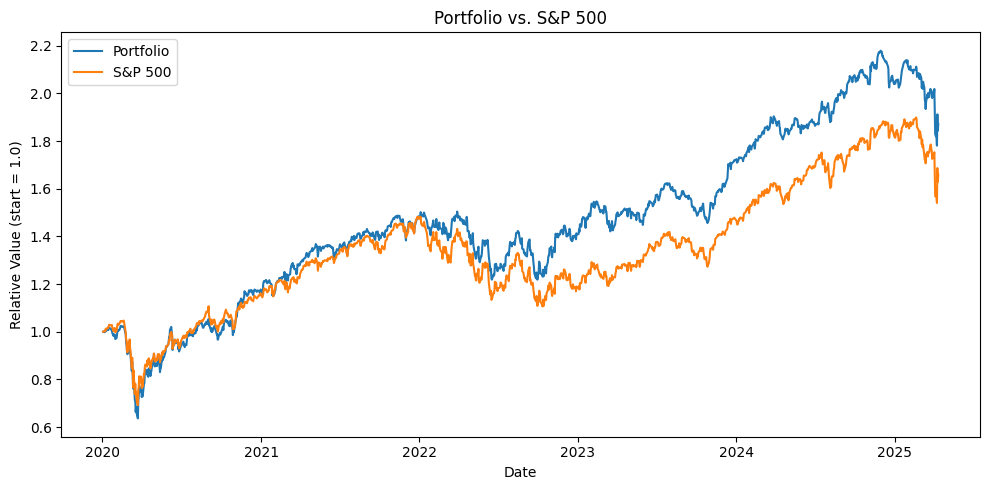

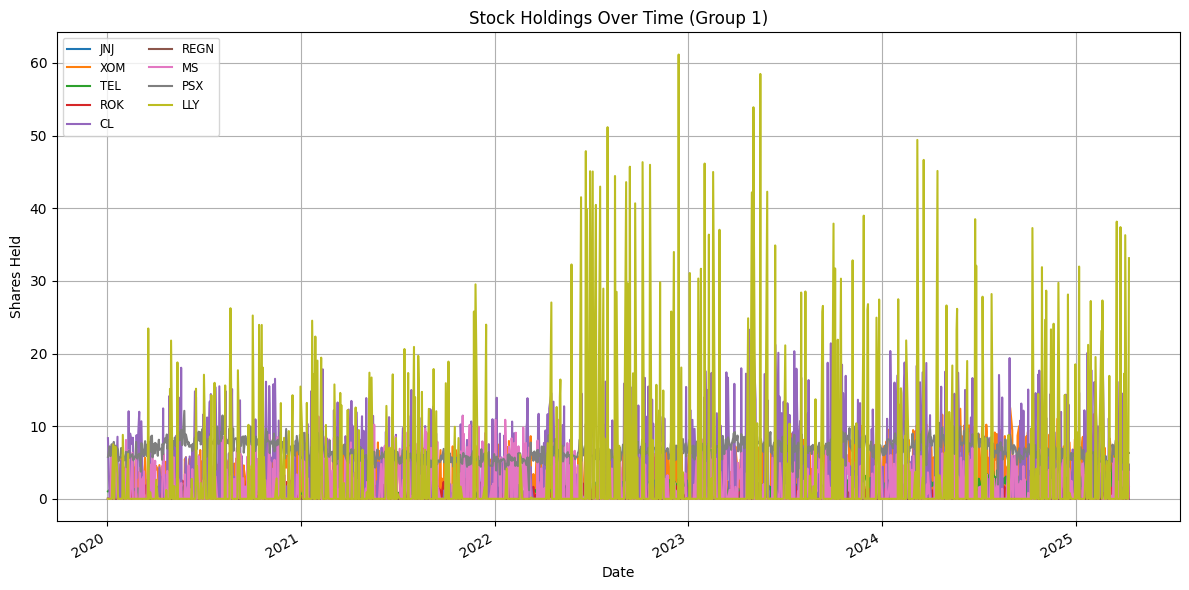

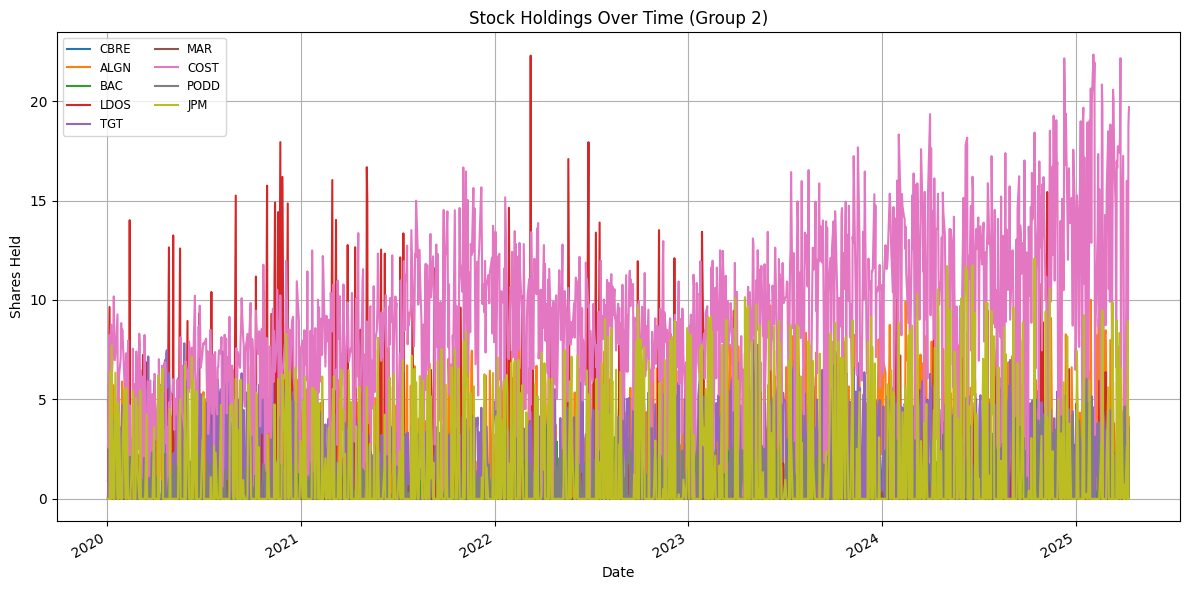

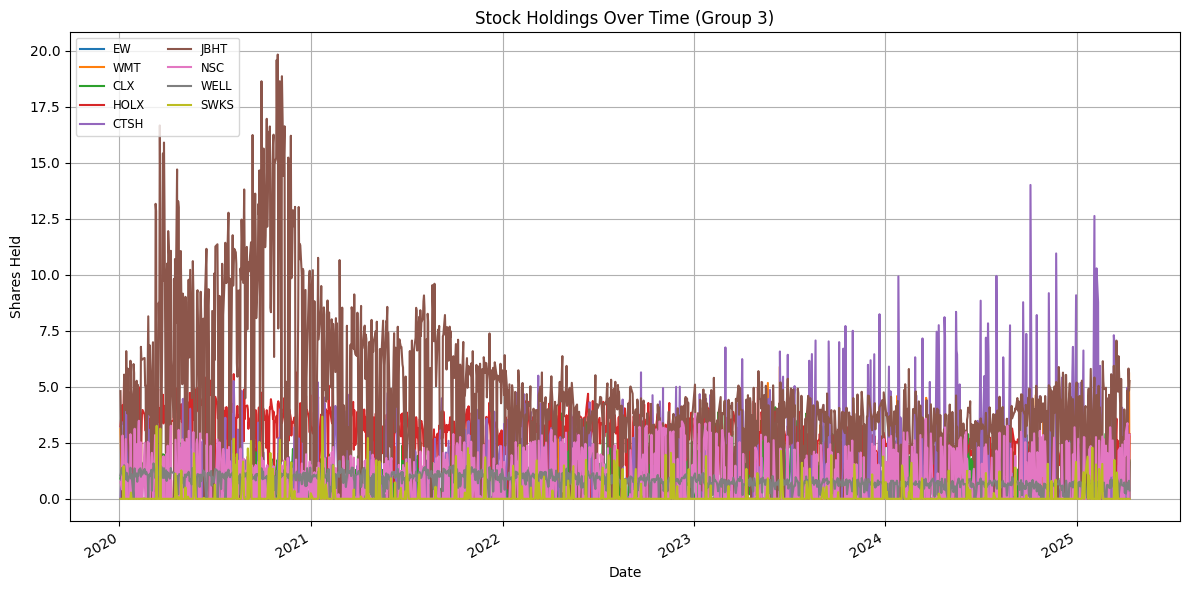

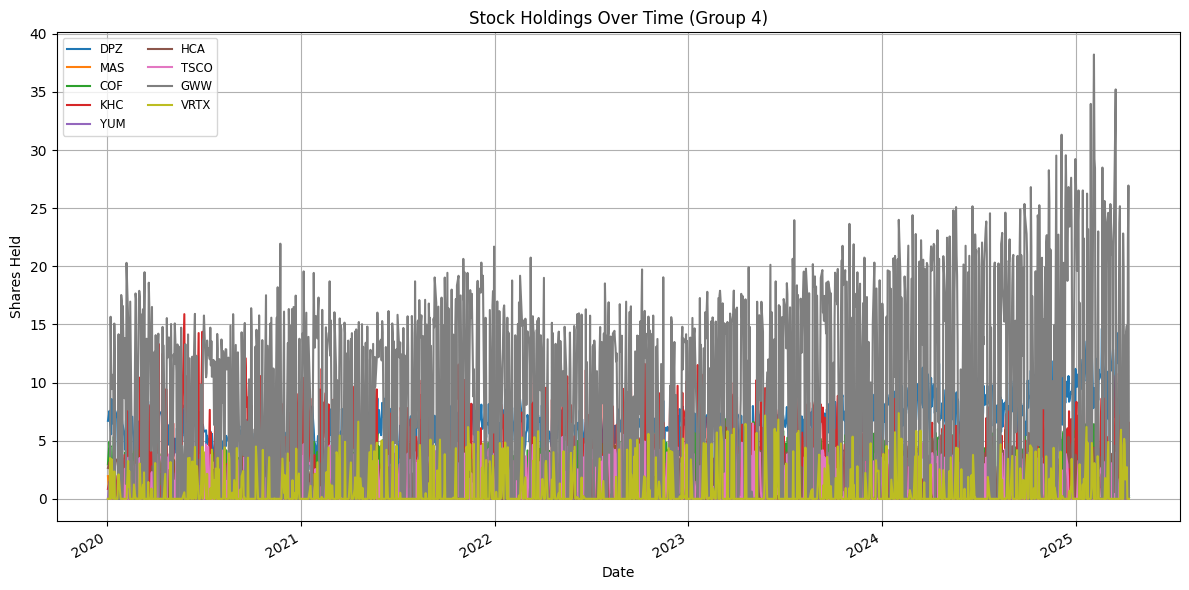

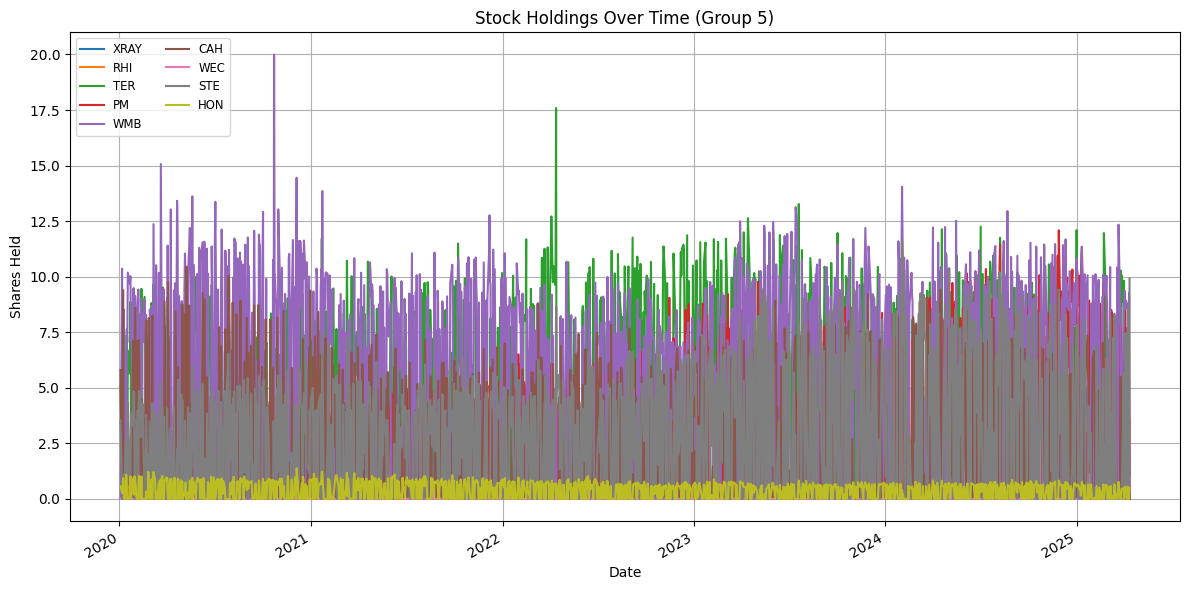

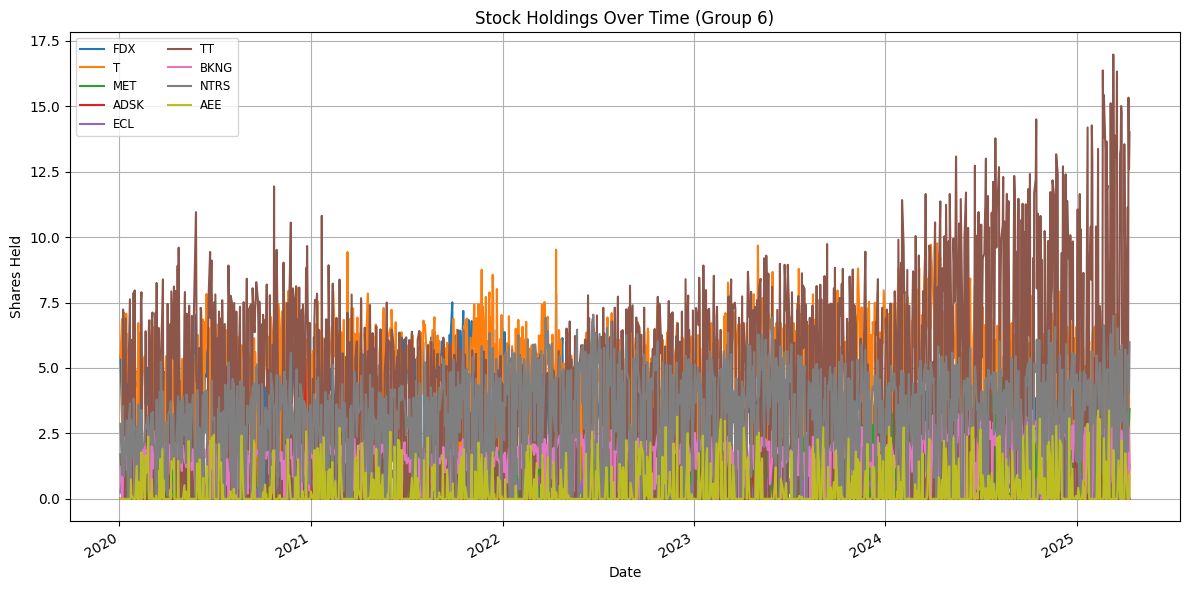

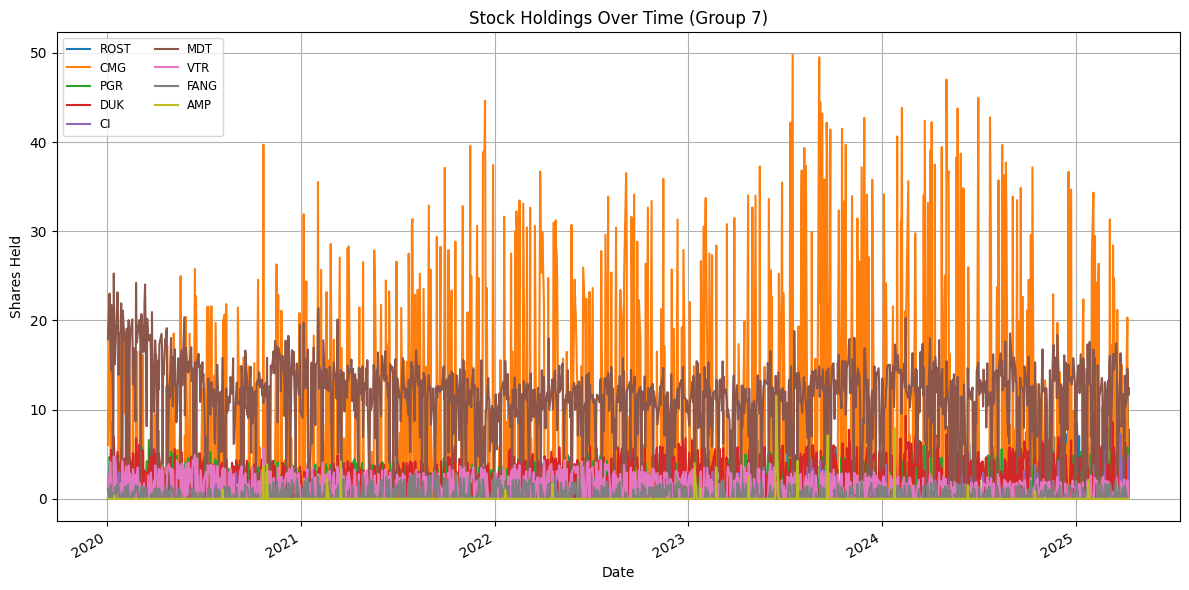

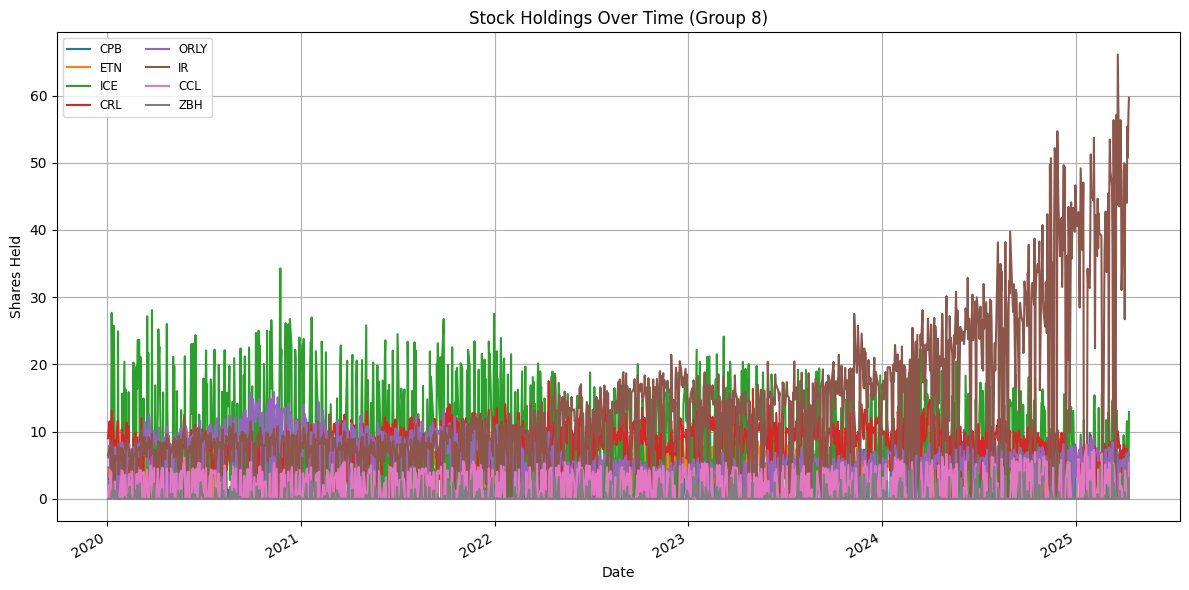

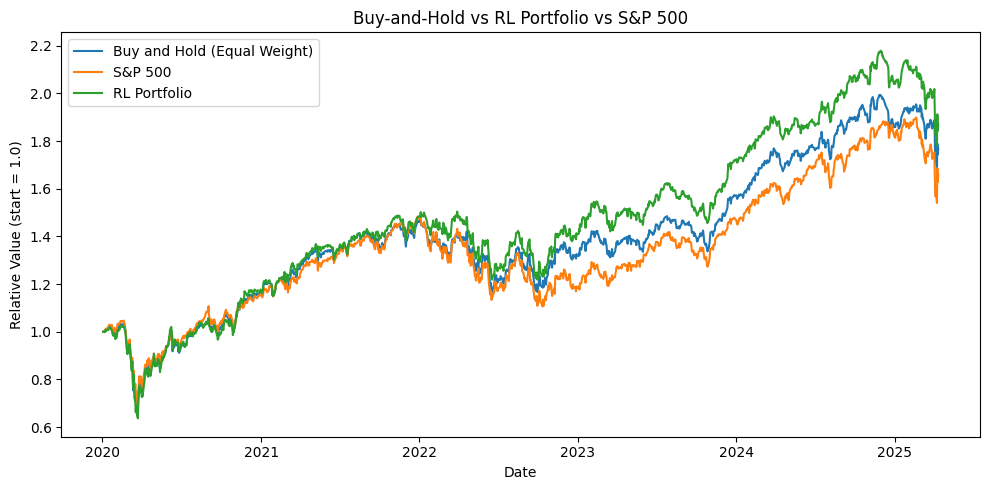

model_return: 86.10216695774437 sp500_return: [65.79933] buy_and_hold_return: 76.82998582126557


/scratch/4632092.1.cds-gpu/ipykernel_527414/1202845789.py:293: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bh_return = (portfolio_val[-1] / portfolio_val[0] - 1) * 100


In [84]:
import gym
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
from gym import spaces

# ------------------------------------------------------------------------
# Full evaluate_agent with individual-holdings plots (8 panels)
# ------------------------------------------------------------------------
def evaluate_agent(agent,
                   tickers,
                   start_date='2020-01-01',
                   end_date=None,
                   initial_cash=100_000,
                   transaction_cost=1e-5,
                   device=None):
    # --------------------------------------------------------------------
    # 1) Download and prepare market data (prices & S&P500)
    # --------------------------------------------------------------------
    price_df = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        auto_adjust=True
    )["Close"].ffill().bfill()
    prices = price_df.values.astype(np.float32)
    dates  = price_df.index

    snp_series = yf.download(
        '^GSPC',
        start=start_date,
        end=end_date,
        auto_adjust=True
    )["Close"].ffill().bfill()
    snp_vals = snp_series.values.astype(np.float32)

    # --------------------------------------------------------------------
    # 2) Assume these arrays & stats were computed during training:
    #    divs_arr, vols_arr, irate_arr,
    #    mu_price, std_price,
    #    mu_div,   std_div,
    #    mu_vol,   std_vol,
    #    mu_ir,    std_ir
    # --------------------------------------------------------------------

    class EvalEnv(gym.Env):
        def __init__(self, prices, divs, vols, irate, snp500,
                     initial_cash=10_000, transaction_cost=1e-5):
            super().__init__()
            self.prices_raw       = prices
            self.divs_raw         = divs
            self.vols_raw         = vols
            self.irate_raw        = irate
            self.snp500           = snp500[: prices.shape[0]]
            self.T, self.N        = prices.shape
            self.initial_cash     = initial_cash
            self.transaction_cost = transaction_cost

            # normalization stats from training
            self.mu_p, self.sd_p = mu_price, std_price
            self.mu_d, self.sd_d = mu_div,   std_div
            self.mu_v, self.sd_v = mu_vol,   std_vol
            self.mu_i, self.sd_i = mu_ir,    std_ir

            self.action_space = spaces.Box(
                low=0, high=1, shape=(self.N + 1,), dtype=np.float32
            )
            obs_dim = self.N*3 + self.N + 1 + 1
            self.observation_space = spaces.Box(
                low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32
            )

        def reset(self):
            self.current_step = 0
            self.cash         = float(self.initial_cash)
            self.holdings     = np.zeros(self.N, dtype=np.float32)
            return self._get_obs()

        def _get_obs(self):
            t = self.current_step
            p = (self.prices_raw[t] - self.mu_p) / self.sd_p
            d = (self.divs_raw[t]   - self.mu_d) / self.sd_d
            v = (self.vols_raw[t]   - self.mu_v) / self.sd_v
            i = (self.irate_raw[t]  - self.mu_i) / self.sd_i
            return np.concatenate([
                p, d, v,
                self.holdings,
                [self.cash],
                [i]
            ]).astype(np.float32)

        def step(self, action):
            # terminal check
            if self.current_step >= self.T - 1:
                return self._get_obs(), 0.0, True, {}

            # normalize & clip action
            action = np.clip(action, 1e-6, None)
            total  = action.sum()
            if total <= 0 or np.isnan(total):
                action = np.zeros_like(action)
                action[-1] = 1.0
            else:
                action = action / total

            prices     = np.clip(self.prices_raw[self.current_step], 1e-3, None)
            stock_vals = self.holdings * prices
            tot_value  = stock_vals.sum() + self.cash

            # compute targets
            target_stock_vals = action[:-1] * tot_value
            target_cash       = action[-1]  * tot_value
            new_holdings      = target_stock_vals / prices

            # transaction cost
            trades   = np.abs(new_holdings - self.holdings) * prices
            turnover = trades.sum()
            cost     = self.transaction_cost * turnover

            # next step prices
            next_prices = np.clip(
                self.prices_raw[self.current_step + 1], 1e-3, None
            )
            next_stock_value = (new_holdings * next_prices).sum()
            next_tot_value   = next_stock_value + target_cash - cost

            # handle numerical issues
            if np.isnan(next_tot_value) or np.isinf(next_tot_value):
                return self._get_obs(), -1.0, True, {}

            # reward = (portfolio return) - (S&P return)
            port_ret = next_tot_value / tot_value - 1
            snp_ret  = (
                self.snp500[self.current_step + 1]
                / self.snp500[self.current_step]
                - 1
            )
            reward = port_ret - snp_ret

            # state update
            self.holdings     = new_holdings
            self.cash         = target_cash - cost
            self.current_step += 1
            done = (self.current_step >= self.T - 1)

            return self._get_obs(), reward, done, {}

    # --------------------------------------------------------------------
    # 3) Instantiate env and run deterministic evaluation
    # --------------------------------------------------------------------
    env = EvalEnv(
        prices, divs_arr, vols_arr, irate_arr, snp_vals,
        initial_cash=initial_cash,
        transaction_cost=transaction_cost
    )

    state = env.reset()

    portf_vals, bench_vals = [], []
    holdings_history = []
    dates_hist      = []

    # --------------------------------------------------------------------
    # 4) Evaluation loop with history recording
    # --------------------------------------------------------------------
    while True:
        action = agent.select_action(state)
        next_state, _, done, _ = env.step(action)
        state = next_state

        t = env.current_step
        dates_hist.append(dates[t])
        portf_vals.append(env.cash + (env.holdings * env.prices_raw[t]).sum())
        bench_vals.append(env.snp500[t])
        holdings_history.append(env.holdings.copy())

        if done:
            break

    # --------------------------------------------------------------------
    # 5) Print returns
    # --------------------------------------------------------------------
    cum_return   = (portf_vals[-1] / initial_cash - 1) * 100
    bench_return = (bench_vals[-1] / bench_vals[0] - 1) * 100
    print(f"Evaluation from {dates[0].date()} to {dates[-1].date()}")
    print(f"Portfolio Cumulative Return: {cum_return:.2f}%")
    print(f"Benchmark (S&P500) Return: {float(bench_return):.2f}%")

    # --------------------------------------------------------------------
    # 6) Normalize & plot Portfolio vs. S&P500
    # --------------------------------------------------------------------
    portf_arr  = np.array(portf_vals, dtype=np.float32)
    bench_arr  = np.array(bench_vals, dtype=np.float32)
    norm_pf    = portf_arr / portf_arr[0]
    norm_bench = bench_arr / bench_arr[0]
    xs = dates[1 : 1 + len(norm_pf)]

    plt.figure(figsize=(10, 5))
    plt.plot(xs, norm_pf,    label='Portfolio')
    plt.plot(xs, norm_bench, label='S&P 500')
    plt.xlabel('Date')
    plt.ylabel('Relative Value (start = 1.0)')
    plt.title('Portfolio vs. S&P 500')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --------------------------------------------------------------------
    # 7) Build holdings DataFrame
    # --------------------------------------------------------------------
    holdings_arr = np.vstack(holdings_history)
    holdings_df  = pd.DataFrame(
        holdings_arr,
        index=pd.to_datetime(dates_hist),
        columns=tickers
    )

    # --------------------------------------------------------------------
    # 8) Plot individual holdings in 8 panels
    # --------------------------------------------------------------------
    num_plots        = 8
    tickers_per_plot = int(np.ceil(len(tickers) / num_plots))

    for i in range(num_plots):
        start_i = i * tickers_per_plot
        end_i   = start_i + tickers_per_plot
        subset  = tickers[start_i:end_i]
        if not subset:
            continue

        fig, ax = plt.subplots(figsize=(12, 6))
        holdings_df[subset].plot(ax=ax)

        ax.set(
            xlabel="Date",
            ylabel="Shares Held",
            title=f"Stock Holdings Over Time (Group {i+1})"
        )
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
        ax.legend(loc="upper left", ncol=2, fontsize="small")
        ax.grid(True)

        plt.tight_layout()
        plt.show()
        
    # --------------------------------------------------------------------
    # 9) Plot Buy-and-Hold Portfolio for Comparison
    # --------------------------------------------------------------------
    buy_hold_prices = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        auto_adjust=True,
        progress=False
    )["Close"].ffill().bfill()

    # Align with evaluation period
    buy_hold_prices = buy_hold_prices.loc[dates_hist]
    buy_hold_prices = buy_hold_prices.dropna(axis=1)  # Drop tickers that failed

    if not buy_hold_prices.empty:
        # Equal weight initial investment
        initial_allocation = initial_cash / len(buy_hold_prices.columns)
        num_shares = initial_allocation / buy_hold_prices.iloc[0]

        # Calculate portfolio value over time
        portfolio_val = (buy_hold_prices * num_shares).sum(axis=1)

        # Normalize
        portfolio_val_norm = portfolio_val / portfolio_val.iloc[0]
        benchmark_val_norm = bench_arr / bench_arr[0]
        xs_bh = pd.to_datetime(dates_hist)

        plt.figure(figsize=(10, 5))
        plt.plot(xs_bh, portfolio_val_norm, label='Buy and Hold (Equal Weight)')
        plt.plot(xs_bh, benchmark_val_norm, label='S&P 500')
        plt.plot(xs_bh, norm_pf, label='RL Portfolio')
        plt.xlabel('Date')
        plt.ylabel('Relative Value (start = 1.0)')
        plt.title('Buy-and-Hold vs RL Portfolio vs S&P 500')
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("Buy-and-hold price data could not be fully aligned with evaluation dates.")
        
    model_return = cum_return
    sp500_return = (bench_vals[-1] / bench_vals[0] - 1) * 100
    bh_return = (portfolio_val[-1] / portfolio_val[0] - 1) * 100

    print(f"model_return: {model_return} sp500_return: {sp500_return} buy_and_hold_return: {bh_return}")

# ------------------------------------------------------------------------
# Example usage
# ------------------------------------------------------------------------
if __name__ == "__main__":
    swag = evaluate_agent(
        agent,
        sampled_tickers,
        start_date='2020-01-01',
        end_date='2025-04-14',
        initial_cash=10000,
        transaction_cost=1e-5,
        device=device
    )